# Taller Práctico #4 – Detección y Segmentación con YOLO + SAM
📅 Fecha: 2025-06-14

Este notebook implementa un pipeline completo que combina detección con YOLOv8 y segmentación con SAM.

## 📂 Cambia tus imágenes aquí:
**Sube tus imágenes en la sección 'images/' o usa URLs en la celda correspondiente.**


In [2]:
# Instalación de dependencias
%pip install ultralytics segment-anything opencv-python matplotlib supervision
%pip install git+https://github.com/facebookresearch/segment-anything.git


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\danga\appdata\local\temp\pip-req-build-37eeov6g
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\danga\AppData\Local\Temp\pip-req-build-37eeov6g'


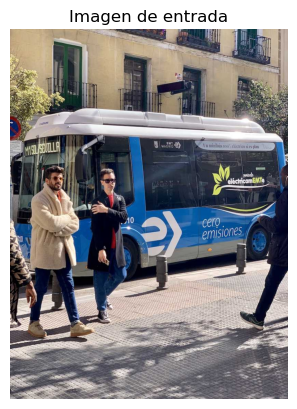

In [5]:
# 📥 Carga de imagen desde URL o subida
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# URL de ejemplo (puedes cambiarla por otra imagen)
url = 'https://ultralytics.com/images/bus.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')
image_np = np.array(image)
plt.savefig('images/imagen_entrada.png')
plt.imshow(image_np)
plt.axis('off')
plt.title('Imagen de entrada')
plt.show()

In [6]:
# 🚀 Detección con YOLOv8
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Puedes usar yolov8s.pt o yolov8m.pt
results = model.predict(image_np, save=False, conf=0.4)

boxes = results[0].boxes.xyxy.cpu().numpy()
clases = results[0].boxes.cls.cpu().numpy()
names = results[0].names

# Mostrar resultados
for result in results:
    result.show()

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\danga\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


KeyboardInterrupt: 

In [ ]:
# 🧠 Segmentación con SAM
from segment_anything import sam_model_registry, SamPredictor

# Cargar modelo (previamente descargado o manual)
sam = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')
predictor = SamPredictor(sam)
predictor.set_image(image_np)

masks = []
for box in boxes:
    box_prompt = np.array([box], dtype=np.float32)
    mask, _, _ = predictor.predict(box=box_prompt[0], multimask_output=False)
    masks.append(mask[0])

# Visualización de máscaras
for i, mask in enumerate(masks):
    plt.imshow(mask, cmap='gray')
    plt.title(f'Máscara {i+1}')
    plt.axis('off')
    plt.show()

In [ ]:
# 🧪 Análisis sobre las máscaras: área y recortes
import os
os.makedirs('recortes', exist_ok=True)

for i, mask in enumerate(masks):
    coords = np.where(mask)
    if coords[0].size > 0:
        miny, maxy = np.min(coords[0]), np.max(coords[0])
        minx, maxx = np.min(coords[1]), np.max(coords[1])
        cropped = image_np[miny:maxy, minx:maxx]
        plt.imsave(f'recortes/objeto_{i+1}.png', cropped)
        print(f'Guardado recorte objeto {i+1}')